In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
## Downloading the database
import kagglehub


# Download latest version
path = kagglehub.dataset_download("ellipticco/elliptic-data-set")

print("Path to dataset files:", path)

/Users/anatol/Desktop/Coding/python/AML/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/anatol/.cache/kagglehub/datasets/ellipticco/elliptic-data-set/versions/1


In [3]:
classes_df = pd.read_csv(path + "/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
features_df = pd.read_csv(path + "/elliptic_bitcoin_dataset/elliptic_txs_features.csv")
edge_df = pd.read_csv(path + "/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")

print(classes_df.head(), end="\n\n")
print(features_df.head(), end="\n\n")
print(edge_df.head())

        txId    class
0  230425980  unknown
1    5530458  unknown
2  232022460  unknown
3  232438397        2
4  230460314  unknown

   230425980  1  -0.1714692896288031  -0.18466755143291433  \
0    5530458  1            -0.171484             -0.184668   
1  232022460  1            -0.172107             -0.184668   
2  232438397  1             0.163054              1.963790   
3  230460314  1             1.011523             -0.081127   
4  230459870  1             0.961040             -0.081127   

   -1.2013688016765636  -0.12196959975910057  -0.04387454791734898  \
0            -1.201369             -0.121970             -0.043875   
1            -1.201369             -0.121970             -0.043875   
2            -0.646376             12.409294             -0.063725   
3            -1.201369              1.153668              0.333276   
4            -1.201369              1.303743              0.333276   

   -0.11300200928476244  -0.06158379407303222  -0.16209679981659642  ... 

In [4]:
# print(classes_df.head(), end="\n\n")
# print(features_df.head(), end="\n\n")
print(edge_df.head())

       txId1      txId2
0  230425980    5530458
1  232022460  232438397
2  230460314  230459870
3  230333930  230595899
4  232013274  232029206


         txId
class        
3      157205
1        4545
2       42019


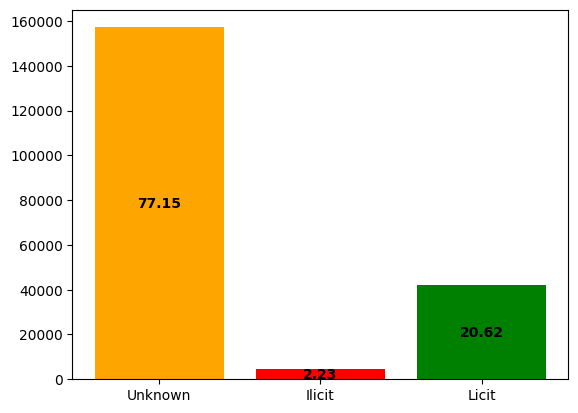

In [5]:
classes_df.loc[classes_df['class'] == 'unknown', 'class'] = 3
Class_grouby= classes_df.groupby('class').count()
values = Class_grouby['txId'].values

print(Class_grouby)

total =  np.sum(Class_grouby['txId'].values)

proc_list = []
for i in values:
    proc = (i/total)*100
    proc = np.round(proc,2)
    proc_list.append(proc)

plt.bar(['Unknown', 'Ilicit', 'Licit'], values, color=['orange', 'r', 'g'], )
for i,v in enumerate(values):
    plt.text(i,v/2, str(proc_list[i]), ha= 'center', va = 'center', fontweight = 'bold')
plt.show()

In [6]:
print(f"Class dim: {classes_df.shape}")
print(f"Feature dim: {features_df.shape}")
print(f"Edge dim: {edge_df.shape}")

Class dim: (203769, 2)
Feature dim: (203768, 167)
Edge dim: (234355, 2)


In [7]:
# concatenate the features and classes
data = pd.concat([features_df, classes_df.set_index('txId')], axis=1)
print(f"Data dim: {data.shape}")


Data dim: (407410, 168)


In [9]:
scalar = StandardScaler()
data = scalar.fit_transform(data.drop(columns=['class']))
data = pd.DataFrame(data)

In [11]:
def CNN_GRU(self: nn.Module):
    def __init__(self):
        super().__init__
        self.conv1 = nn.Conv1d(166, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.maxpool = nn.MaxPool1d(2)

        #GRU layer
        self.gru = nn.GRU(128, 128, batch_first=True, bidirectional=True)

        # Fully connected layers
        self.fc = nn.Linear(256, 1)  # 128 * 2 because bidirectional GRU
        self.dropout = nn.Dropout(0.5)
        
        

    def forward(self, x):
        # CNN feature extraction
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)  # Reduce sequence length

        # Reshape for GRU (batch_size, seq_len, input_size)
        x = x.permute(0, 2, 1)  # Convert (batch, channels, seq_len) → (batch, seq_len, channels)

        # GRU processing
        x, _ = self.gru(x)

        # Take the last hidden state
        x = x[:, -1, :]

        # Fully connected layer
        x = self.fc(self.dropout(x))

        return x  # No sigmoid applied, use BCEWithLogitsLoss() for stability

In [ ]:
def contrastive_loss(self, z_i, z_j, z_k):
    """
    Compute contrastive loss as defined in the paper:
    L = -log(exp(sim(z_i, z_j)/τ) / (exp(sim(z_i, z_j)/τ) + exp(sim(z_i, z_k)/τ)))
    
    :param z_i: Anchor feature vector representation
    :param z_j: Positive sample feature vector representation
    :param z_k: Negative sample feature vector representation
    :return: Contrastive loss value
    """
    # Compute similarity between anchor and positive sample
    sim_pos = cosine_similarity(z_i, z_j, dim=1) / self.temperature
    
    # Compute similarity between anchor and negative sample
    sim_neg = cosine_similarity(z_i, z_k, dim=1) / self.temperature
    
    # Compute the numerator: exp(sim(z_i, z_j)/τ)
    numerator = torch.exp(sim_pos)
    
    # Compute the denominator: exp(sim(z_i, z_j)/τ) + exp(sim(z_i, z_k)/τ)
    denominator = numerator + torch.exp(sim_neg)
    
    # Compute the negative log-likelihood
    loss = -torch.log(numerator / denominator)
    
    return loss.mean()

def batch_contrastive_loss(self, features):
    """
    Compute contrastive loss over a batch of features
    
    :param features: Tensor of transaction feature vectors
    :return: Contrastive loss value
    """
    batch_size = features.shape[0]

    # Calculate similarity matrix
    similarity_matrix = torch.matmul(features, features.t()) / self.temperature
    
    # Create mask for positive pairs (excluding self-similarity)
    mask_positive = torch.eye(batch_size, dtype=torch.bool).to(features.device)
    mask_positive = ~mask_positive
    
    # For each anchor, calculate the loss
    total_loss = 0
    for i in range(batch_size):
        # Get similarities for current anchor
        anchor_similarities = similarity_matrix[i]
        
        # Numerator: sum of exp(sim(z_i, z_j)/τ) for all positives
        numerator = torch.exp(anchor_similarities[mask_positive[i]])
        
        # Denominator: sum of exp(sim(z_i, z_k)/τ) for all samples
        denominator = torch.sum(torch.exp(anchor_similarities)) - torch.exp(anchor_similarities[i])
        
        # Loss for this anchor
        anchor_loss = -torch.log(numerator / denominator)
        total_loss += anchor_loss.mean()
    
    return total_loss / batch_size

In [10]:
# Convert to PyTorch tensors
X_tensor = torch.tensor(data, dtype=torch.float32)
y_tensor = torch.tensor(classes_df, dtype=torch.float32)

# Create dataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


(407410, 167)


ValueError: could not determine the shape of object type 'Series'

In [ ]:
import torch.optim as optim

# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_GRU().to(device)
criterion = nn.BCEWithLogitsLoss()  # More stable than Sigmoid+BCELoss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        X_batch, y_batch = batch
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")
